# **SMS: Spam or Ham (Beginner)**

For my first kernel on Natural Language Processing (NLP), I chose the SMS Spam Collection Dataset.  
It contains  the text of 5572 SMS messages and a label, classifying the message as "spam" or "ham".

In this kernel I explore some common techniques of NLP like:

* **Removing Punctuation and Stopwords**
* **Tokenizer, Bag of words**  
* **Term frequency inverse document frequency (TFIDF)**

Based on these preprocessing, I train 6 different models that classify **unknown** messages as spam or ham. 

* **Naive Bayes Classifier**
* **SVM Classifier**  
* **KNN Classifier**
* **SGD Classifier**
* **Gradient Boosting Classifier**
* **XGBoost Classifier**

For easier handling of the preprocessing steps (for train and test data) and the optimization of different  
models for the same conditions, the classification is done with **Pipelines** including GridSearchCV.  
Finally, for the model evaluation different **metrics** are examined:  
accuracy, precision, recall, fscore, roc_auc

**Part 0: Imports, define functions**  
[import libraries](#Imports)  
define [functions](#Functions) that are used often  

[**Part 1: Exploratory Data Analysis**](#Part-1:-EDA)  
**1.1 Get an overview of the dataset**  
head, describe and value counts  
[Distribution of the target variable](#Distribution-of-the-target-variable)  
[Add numerical label for spam](#Add-numerical-label-for-spam)  
**1.2 length of message**  
[Add feature: length of message](#Add-feature:-length-of-message)  
**1.3 WordClouds**  
[WordCloud: Ham messages](#WordCloud:-Ham-messages)  
[WordCloud: Spam messages](#WordCloud:-Spam-messages)  

[**Part 2: Preprocessing**](#Part-2:-Preprocessing)  
[**2.1 Remove punctuation and stopwords**](#2.1-Remove-Punctuation-and-Stopwords)   
[**2.2 Top 30 words in ham and spam messages**](#2.2-Top-30-words-in-ham-and-spam-messages)  
**2.3 Bag of words with CountVectorizer**  
[The Bag of Words representation](#The-Bag-of-Words-representation)  
[Examples for spam and ham messages](#Examples-for-spam-and-ham-messages)  
[Applying bow_transformer on all messages](#Applying-bow_transformer-on-all-messages)  
**2.4 Term frequency inverse document frequency (TFIDF)**  
[From occurrences to frequencies](#From-occurrences-to-frequencies)  
[TfidfTransformer from sklearn](#TfidfTransformer-from-sklearn)  
[**Part 3: Classifiers**](#Part-3:-Classifiers)  
[**3.1 First test for Classification**](#3.1-First-test-for-Classification) with Naive Bayes Classifier  
[**3.2 train test split**](#3.2-train-test-split)  
**3.3 Pipelines for Classification of unknown messages**  
[Multinomial Naive Bayes](#3.3.1-MultinomialNB)  (simple: Preprocessing and Classification)  
[KNN Classifier](#3.3.2-KNN)  (GridSearchCV for model parameter)   
[Support Vector Classifier](#3.3.3-SVC)  (GridSearchCV for Preprocessing)  
[SGD Classifier](#3.3.4-SGD)  (GridSearchCV for Preprocessing and model parameter)  
[GradientBoostingClassifier](#3.3.5-GradientBoostingClassifier)    (GridSearchCV for Preprocessing and model parameter)  
[XGBoost Classifier](#3.3.6-XGBoost-Classifier)    (GridSearchCV for Preprocessing and model parameter)  
**3.4 Comparison of results**  
[confusion_matrix](#confusion_matrix) +++ [accuracy_score](#accuracy_score)       
[precision_score](#precision_score) +++ [recall_score](#recall_score)  
[f1_score](#f1_score) +++  [classification_report](#classification_report)    
[roc_auc_score](#roc_auc_score)  
**3.5 Optimize classifiers with scoring by precision**  
3.5.1 [GridSearchCV pipelines version 2](#3.5.1-GridSearchCV-pipelines-version-2)  
3.5.2 [Confusion matrices for scoring by precision](#3.5.2-Confusion-matrices-for-scoring-by-precision)  
**3.6 Optimize classifiers with scoring by recall**  
3.6.1 [GridSearchCV pipelines version 3](#3.6.1-GridSearchCV-pipelines-version-3)  
3.6.2 [Confusion matrices for scoring by recall](#3.6.2-Confusion-matrices-for-scoring-by-recall)  
**3.7 Optimize classifiers with scoring by roc_auc**  
3.7.1 [GridSearchCV pipelines version 4](#3.7.1-GridSearchCV-pipelines-version-4)    
3.7.2 [Confusion matrices for scoring by roc auc](#3.7.2-Confusion-matrices-for-scoring-by-roc-auc)  

[**Part 4: NLTK**](#Part-4:-NLTK)

# **Part 0: Imports, define functions** 

## Import Libraries

In [ ]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import wordcloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

## Functions

In [315]:
# print Classification Report and Accuracy

def print_validation_report(y_true, y_pred):
    print("Classification Report")
    print(classification_report(y_true, y_pred))
    acc_sc = accuracy_score(y_true, y_pred)
    print("Accuracy : "+ str(acc_sc))
    
    return acc_sc

# plot_confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    #fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  
                cmap="Blues", cbar=False, ax=ax)
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

# Part 1: EDA

In [316]:
df = pd.read_csv('../data/raw/spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [317]:
# Columns 2,3,4 contain no important data and can be deleted.
# Also, we rename column v1 as "label" and v2 as "text"

df = df.iloc[:,:2]
df.columns = ['label','text']
df.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [318]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [319]:
df['text'] = df['text'].astype('string')

In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   string
dtypes: object(1), string(1)
memory usage: 87.2+ KB


In [321]:
df.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

### Distribution of the target variable

The dataset contains 4825 ham and 747 spam messages.  
For both classes, some messages appear more than once (common phrases, etc.).

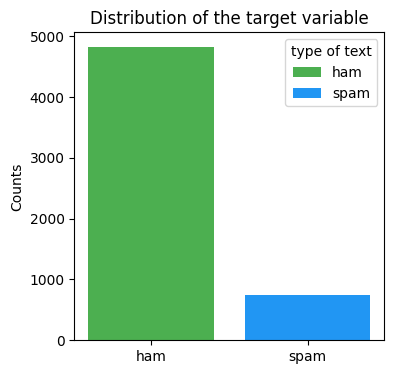

In [322]:
fig, ax =plt.subplots(figsize=(4,4))
label_df = df.groupby('label').count()
label_df.reset_index(inplace=True)

ax.bar(label_df['label'],label_df['text'],color=['#4CAF50', '#2196F3'],label= label_df['label'])
ax.set_ylabel('Counts')
ax.set_title('Distribution of the target variable')
ax.legend(title = 'type of text')

plt.show()

### Add numerical label for spam   
Target must be numerical for ML classification models

In [323]:
df['spam'] = df['label'].map({'spam': 1, 'ham': 0}).astype(int)
df.head(10)

,label,text,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
6,ham,Even my brother is not like to speak with me. ...,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1


## 1.2 lenth of message

### Add feature: length of message

In [324]:
df['length'] = df['text'].apply(len)
df.head(10)

,label,text,spam,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1,148
6,ham,Even my brother is not like to speak with me. ...,0,77
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0,160
8,spam,WINNER!! As a valued network customer you have...,1,158
9,spam,Had your mobile 11 months or more? U R entitle...,1,154


(-40.0, 300.0)

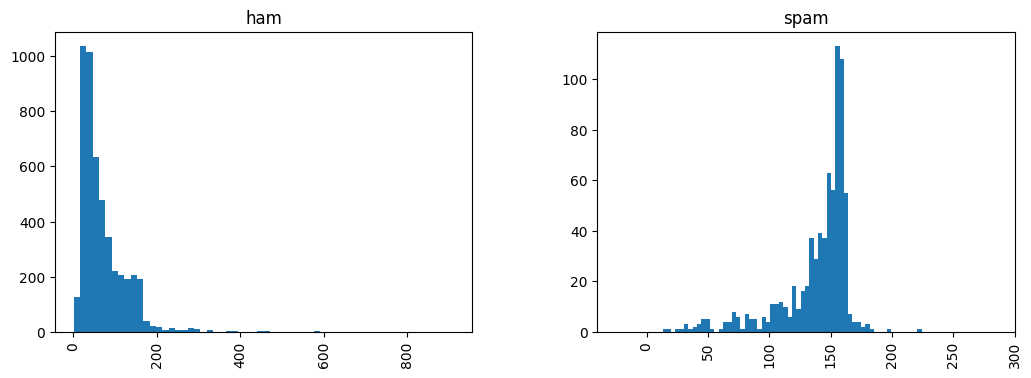

In [325]:
df.hist(column='length',by='label', bins=60,figsize=(12,4))
plt.xlim(-40,300)

Looks like spam messages are generally longer than ham messages:  
Bulk of ham has length below 100, for spam it is above 100.  
We will check if this feature is useful for the classification task in Part 3.  

In [326]:
df_spam = df[df['spam']==1].copy()
df_ham = df[df['spam']==0].copy()

## 1.3 WordClouds

In [327]:
def show_wordcloud(df_spam_or_ham, title):
    text = ' '.join(df_spam_or_ham['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

WordClouds: Ham messages

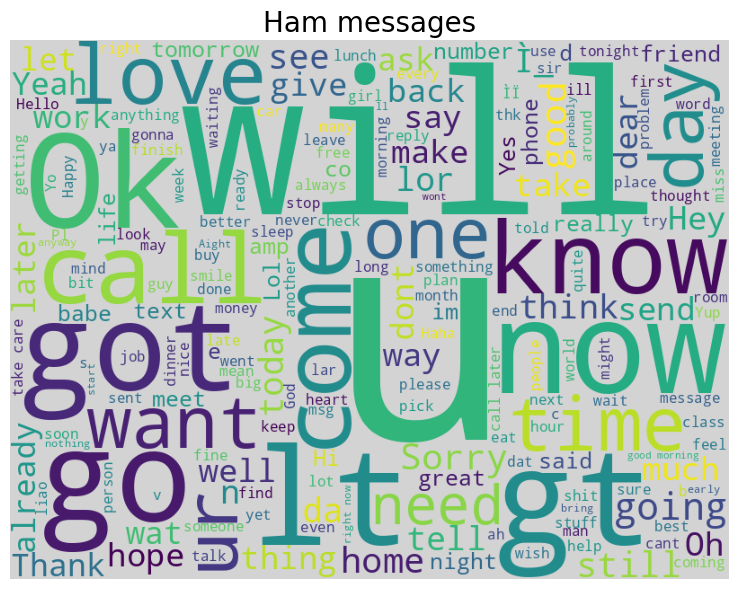

In [328]:
show_wordcloud(df_ham,'Ham messages')

WordCloud: Spam messages

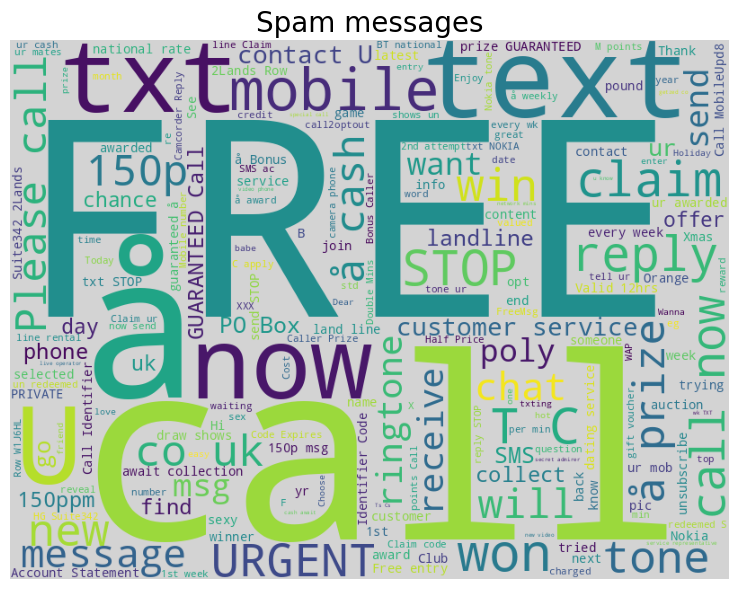

In [329]:
show_wordcloud(df_spam, 'Spam messages')

## Part 2: Preprocessing

Basic preprocessing for common NLP tasks includes converting text to lowercase and removing punctuation and stopwords.

Further steps, especially for text classification tasks, are:

- Tokenization
- Vectorization and
- TF-IDF weighting

## 2.1 Remove Punctuation and Stopwords

### Punctuation
**We use the punctuation list from the string library:**

In [330]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

### Stopwords  
from sklearn documentation:  https://scikit-learn.org/stable/modules/feature_extraction.html#stop-words  
Stop words are words like “and”, “the”, “him”, which are presumed to be uninformative in representing the content of a text,   
and which may be removed to avoid them being construed as signal for prediction.  
Sometimes, however, similar words are useful for prediction, such as in classifying writing style or personality.  

Due to the known issues in the ’english’ stop word list of sklearn, This project use the stopwords from NLTK:

**NLTK**

In [331]:
from nltk.corpus import stopwords
stopwords.words('english')[20:30]

['before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't"]

**With the above lists for punctuation characters and stop words, we define a function to remove these from the text**  
**This function also converts all text to lowercase**

In [332]:
def remove_punctuation_and_stopwords(sms):
    sms_no_punctuation = [ch for ch in sms if ch not in string.punctuation]
    sms_no_punctuation = ''.join(sms_no_punctuation).split()

    sms_no_punctuation_no_stopwords = \
        [word.lower() for word in sms_no_punctuation if word.lower() not in stopwords.words('english')]
     # line continuation character

    return sms_no_punctuation_no_stopwords

In [333]:
df['text'].apply(remove_punctuation_and_stopwords).head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: text, dtype: object

### 2.2 Top 30 words in ham and spam messages

#### 2.2.1 Collections: Counter

In [334]:
from collections import Counter

In [335]:
df_ham['tokens'] = df_ham['text'].apply(remove_punctuation_and_stopwords)
words_df_ham = df_ham['tokens'].to_list()
df_spam['tokens'] = df_spam['text'].apply(remove_punctuation_and_stopwords)
words_df_spam = df_spam['tokens'].to_list()


In [336]:
list_ham_words = []
for sublist in words_df_ham:
    for item in sublist:
        list_ham_words.append(item)

In [337]:
list_spam_words = []
for sublist in words_df_spam:
    for item in sublist:
        list_spam_words.append(item)

In [338]:
c_ham  = Counter(list_ham_words)
c_spam = Counter(list_spam_words)
df_hamwords_top30  = pd.DataFrame(c_ham.most_common(30),  columns=['word', 'count'])
df_spamwords_top30 = pd.DataFrame(c_spam.most_common(30), columns=['word', 'count'])

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, 'u'),
  Text(1, 0, 'im'),
  Text(2, 0, '2'),
  Text(3, 0, 'get'),
  Text(4, 0, 'ltgt'),
  Text(5, 0, 'ok'),
  Text(6, 0, 'dont'),
  Text(7, 0, 'go'),
  Text(8, 0, 'ur'),
  Text(9, 0, 'ill'),
  Text(10, 0, 'know'),
  Text(11, 0, 'got'),
  Text(12, 0, 'like'),
  Text(13, 0, 'call'),
  Text(14, 0, 'come'),
  Text(15, 0, 'good'),
  Text(16, 0, 'time'),
  Text(17, 0, 'day'),
  Text(18, 0, 'love'),
  Text(19, 0, '4'),
  Text(20, 0, 'going'),
  Text(21, 0, 'want'),
  Text(22, 0, 'one'),
  Text(23, 0, 'home'),
  Text(24, 0, 'lor'),
  Text(25, 0, 'need'),
  Text(26, 0, 'sorry'),
  Text(27, 0, 'still'),
  Text(28, 0, 'see'),
  Text(29, 0, 'n')])

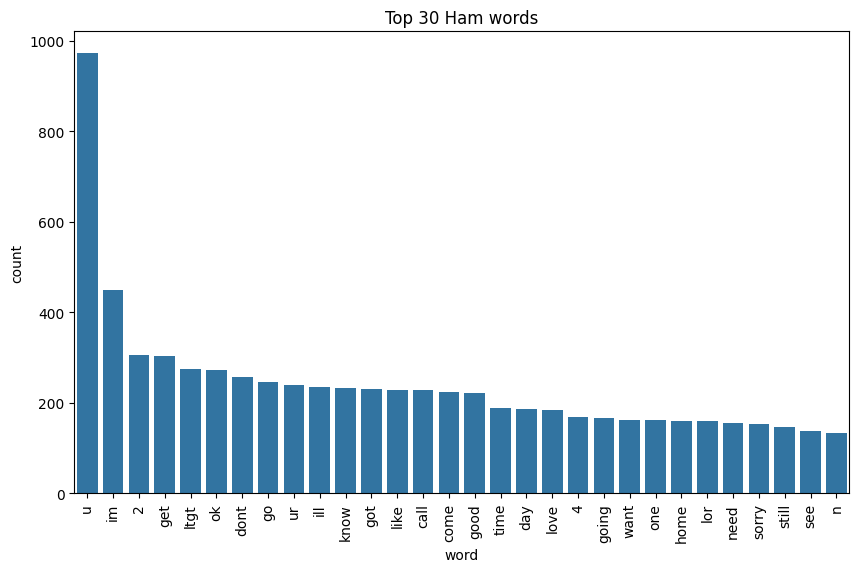

In [339]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_hamwords_top30, ax=ax)
plt.title("Top 30 Ham words")
plt.xticks(rotation='vertical')

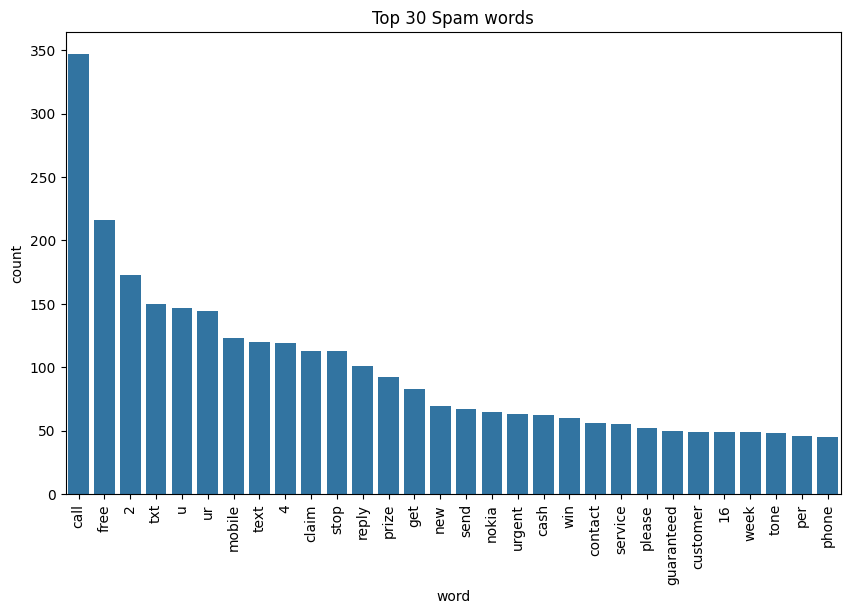

In [340]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_spamwords_top30, ax=ax)
plt.title("Top 30 Spam words")
plt.xticks(rotation='vertical');

#### 2.2.2 NLTK: FreqDist

In [341]:
fdist_ham  = nltk.FreqDist(list_ham_words)
fdist_spam = nltk.FreqDist(list_spam_words)

In [342]:
df_hamwords_top30_nltk  = pd.DataFrame(fdist_ham.most_common(30),  columns=['word', 'count'])
df_spamwords_top30_nltk = pd.DataFrame(fdist_spam.most_common(30), columns=['word', 'count'])

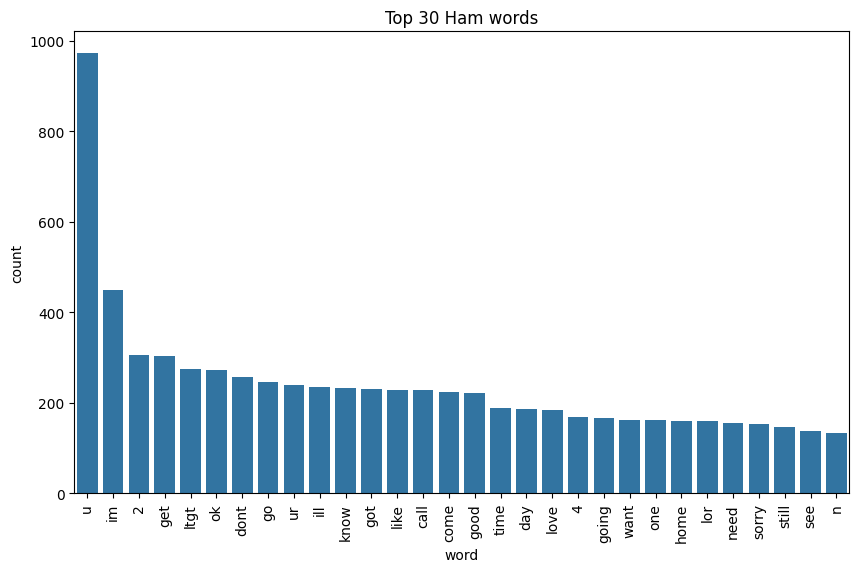

In [343]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_hamwords_top30_nltk, ax=ax)
plt.title("Top 30 Ham words")
plt.xticks(rotation='vertical');

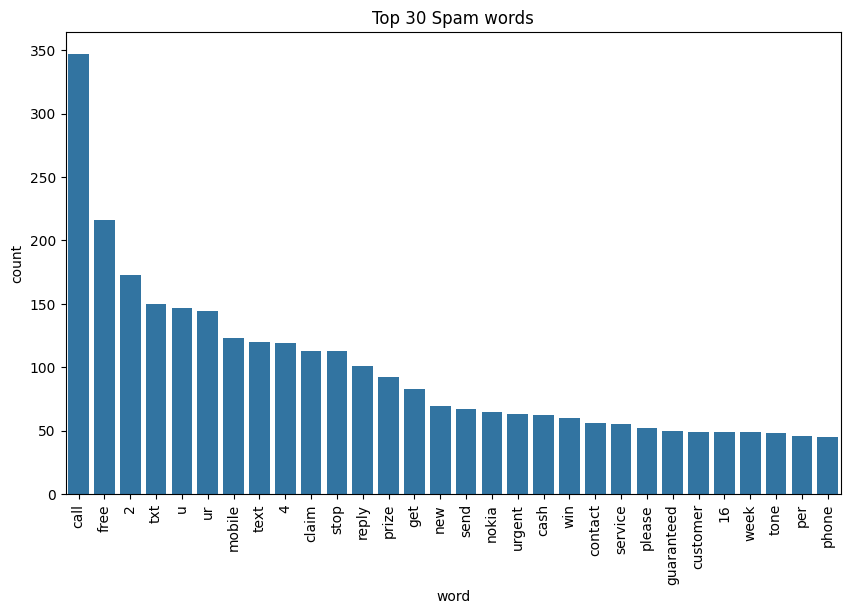

In [344]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_spamwords_top30_nltk, ax=ax)
plt.title("Top 30 Spam words")
plt.xticks(rotation='vertical');

## 2.2 Bag of words with CountVectorizer